<a href="https://colab.research.google.com/github/ai-fast-track/visual-guide/blob/master/02_image-classification-multi-label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://digimedsystems.com/images/run-a-cell.png)

In [1]:
# Install fastai2 from pypi
!pip install fastai2

     |████████████████████████████████| 194kB 2.8MB/s 


In [2]:
# fastai2 imports
from fastai2.vision.all import *

## End-to-End Training Workflow

![](https://digimedsystems.com/images/end-to-end-training-workflow-medium.png)

## 1- Download Data
Download dataset and save in `~/.fastai/data` folder

In [3]:
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/"train.csv")

In [4]:
df.sample(5)

,fname,labels,is_valid
1169,002347.jpg,pottedplant,False
3672,007270.jpg,car person,True
4968,009874.jpg,horse person,False
3794,007526.jpg,person horse,False
445,000896.jpg,aeroplane,True


## 2- Create a fastai2 DataBlock
Check out the video below for more details

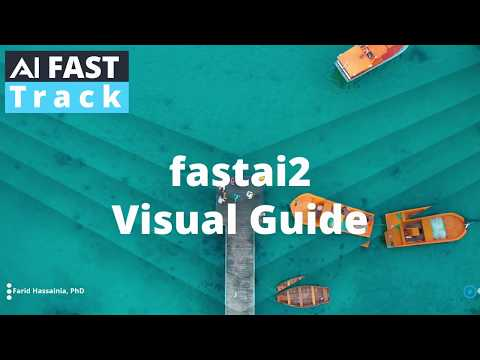

In [5]:
from IPython.display import YouTubeVideo
# Image classification with a single label (Pet Dataset)
# Video credit: AI Fast Track.
YouTubeVideo('BBMTeK_zYdw', width=600, height=400) 

![](https://digimedsystems.com/images/image-classification-multi-label-medium.png)

In [6]:
# Create a DataBlock: check the animation shown in the video and/or the the illustration here above 
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=path/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [7]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: ColReader -> PILBase.create
Setting up Pipeline: ColReader -> MultiCategorize -> OneHotEncode

Building one sample
  Pipeline: ColReader -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying ColReader gives
      /root/.fastai/data/pascal_2007/train/000012.jpg
    applying PILBase.create gives
      PIL

In [8]:
tfms = aug_transforms()
tfms

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 LightingTfm: (TensorImage,object) -> encodes ]

In [11]:
# Choose a example and get the image filename
fname = df.iloc[2]['fname']
fname
# '000009.jpg'

'000009.jpg'

In [12]:
# Full qualified image filename
img_fname = path/"train"/fname
img_fname
# Path('/root/.fastai/data/pascal_2007/train/000009.jpg')

Path('/root/.fastai/data/pascal_2007/train/000009.jpg')

((500, 375), <matplotlib.axes._subplots.AxesSubplot at 0x7fc0290c0e80>)

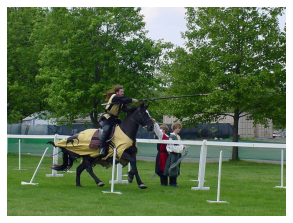

In [17]:
img = PILImage.create(img_fname)
img.size, img.show()

((224, 224), <matplotlib.axes._subplots.AxesSubplot at 0x7fc02979cef0>)

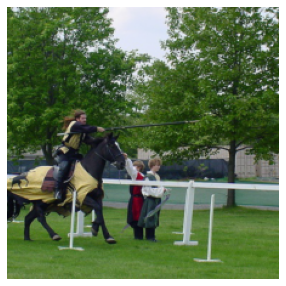

In [19]:
tfm_resize = Resize(224)
img_resized= tfm_resize(img)
img_resized.size, img_resized.show()

In [27]:
type(img_resized)

fastai2.vision.core.PILImage

In [28]:
img_tensor = ToTensor(img_resized)
type(img_tensor)

fastai2.data.transforms.ToTensor

In [21]:
tfms_aug = aug_transforms()
tfms_aug

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 LightingTfm: (TensorImage,object) -> encodes ]

In [29]:
img_aug = compose_tfms(img_tensor, tfms=tfms_aug)
img_aug.size, img_aug.show()

AttributeError: ignored

## 3- Create a DataLoaders Object

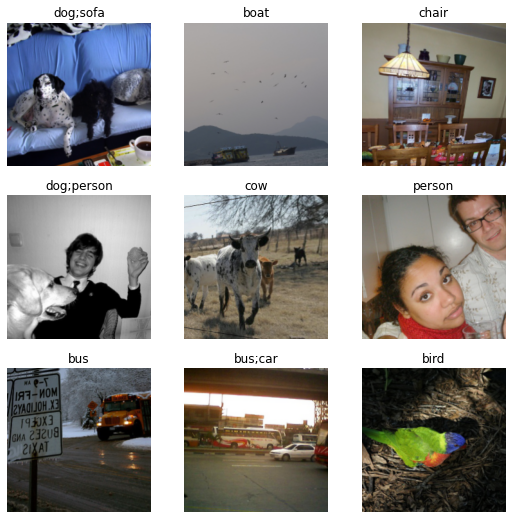

In [30]:
# Create a DataLoaders objet
# Show a sample batch
dls = dblock.dataloaders(df)
dls.sMbhow_batch()

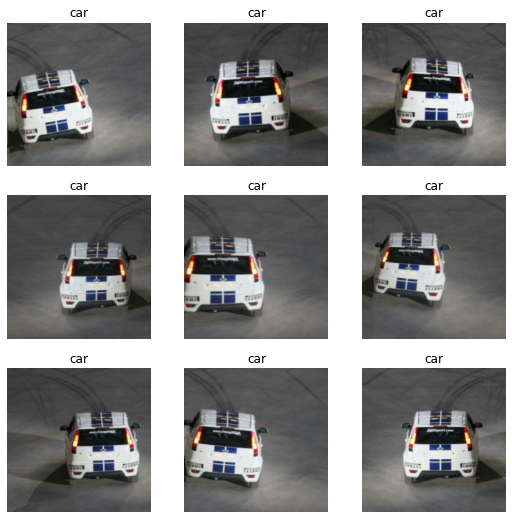

In [31]:
dls.show_batch(unique=True)

## 4- Create a Learner Object
In this example we are using a pretrained resnet34 model.

Learner wraps:
- A DataLoaders object: dls
- A model: a pretrained restnet34
- A function loss: set automatically in this case

- A metrics: partial(accuracy_multi, thresh=0.2)
- thresh=0.2 means if the activation (last layer: Sigmoid) is greater than 0.2 then mark the correspnding object as present

In [32]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Note: 
fastai detects that it is a Multi-Label Classification use-case

It will automatically add the function loss `func_loss=BCEWithLogitsLossFlat()`

The code above (`learn = cnn_learner(dls,...)`) is equivalent to:

`learn = cnn_learner(dls, resnet50, func_loss=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.2))`

## 5- Train model
`fine_tune` method takes care of training the model by following these 2 steps:

1- Freeze the model body, and only train the head.

2- Unfreeze the body, and train the whole model.

More on these techniques soon!

### `fine_tune()` definition
```
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
```

Under the hood the fine_tune() method uses fit_one_cycle()
- fit_one_cycle() is the method that trains our model for one epoch
- One epoch means that the model will see (be trained using) all the images belonging to the train dataset
- it freezes the the body of the model, and train the head of the model for a number of epochs equal to `freeze_epochs`
- then it unfreezes the whole model (body + head), and train the whole of the model for a number of epochs equal to `epochs`

In [33]:
# Fine tune resnet model pretrained with the ImageNet dataset
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.927810,0.680809,0.256335,00:31
1,0.793985,0.512573,0.340458,00:31
2,0.574476,0.177726,0.830956,00:31
3,0.329685,0.088827,0.962271,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.105122,0.085542,0.964920,00:32
1,0.088712,0.079626,0.968088,00:33
2,0.071234,0.075710,0.966574,00:32


In [34]:
x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [36]:
activ = activs[0]
activ

tensor([ -8.6182,  -8.5257,  -9.6278,  -8.8219,  -5.8690,  -8.5563,  -6.8360,
         12.1004,  -5.5242,  -9.2336,  -8.3157, -10.0467,  -8.2182,  -6.5767,
         -6.2696,  -3.6319,  -8.0120,  -6.1313,  -9.6152,  -5.1355],
       device='cuda:0', grad_fn=<SelectBackward>)

In [37]:
inputs = activ.sigmoid()
inputs

tensor([1.8075e-04, 1.9826e-04, 6.5866e-05, 1.4744e-04, 2.8177e-03, 1.9230e-04,
        1.0732e-03, 9.9999e-01, 3.9733e-03, 9.7688e-05, 2.4458e-04, 4.3325e-05,
        2.6963e-04, 1.3905e-03, 1.8894e-03, 2.5783e-02, 3.3134e-04, 2.1689e-03,
        6.6705e-05, 5.8496e-03], device='cuda:0', grad_fn=<SigmoidBackward>)

In [43]:
thresh = 0.2
inp_bool = inputs>thresh
inp_bool

tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [45]:
inp_bool.int()

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)

In [39]:
rounded = inputs.round()
rounded

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0', grad_fn=<RoundBackward>)

In [40]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [41]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(0.0333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### Plot both train and valid losses

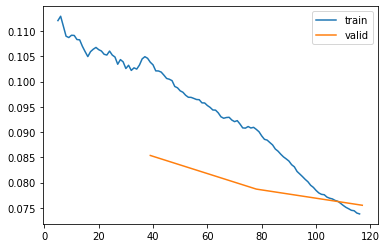

In [ ]:
learn.recorder.plot_loss()

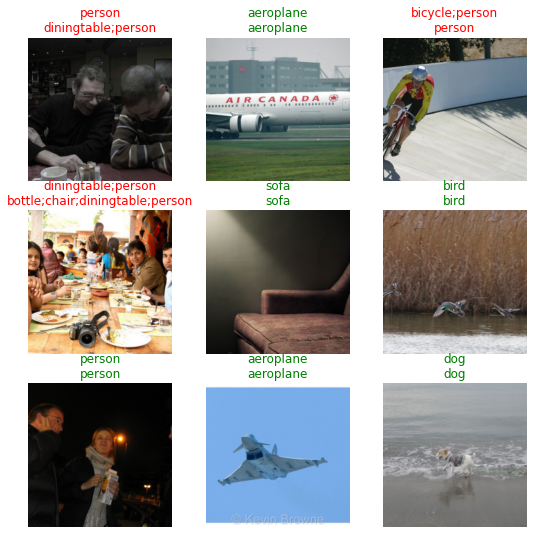

In [ ]:
learn.show_results()

### Train more
Train a bit more (3 more epochs) using discriminative learning rates:

lr_max=slice(1e-5,1e-3) means: 
- Apply lr = 1e-5 (low lr) to the first group of layers
- Apply lr = 1e-4 (medium lr) to the mid group of layers 
- Apply lr = 1e-3 (high lr) to the last group of layers


In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.057063,0.077264,0.967988,01:16
1,0.052280,0.078711,0.969163,01:16
2,0.044085,0.076885,0.967908,01:16


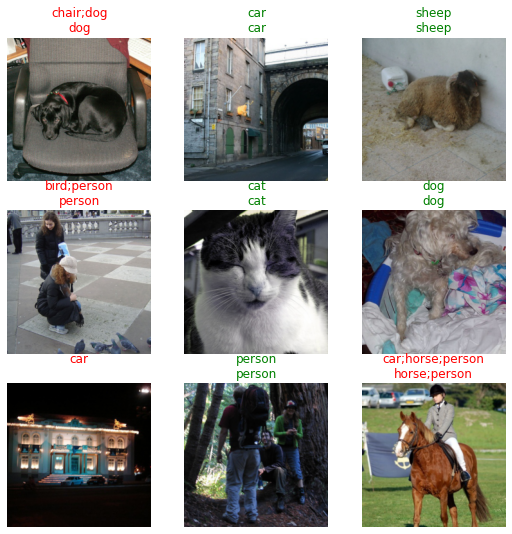

In [ ]:
learn.show_results()

### Train even more
Train for 10 more epochs using discriminative learning rates:

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.037149,0.076683,0.970378,01:16
1,0.035601,0.082522,0.965896,01:16
2,0.036940,0.090416,0.964084,01:16
3,0.033938,0.096828,0.968068,01:16
4,0.030984,0.094155,0.968825,01:16
5,0.025435,0.094647,0.969522,01:16
6,0.020234,0.093982,0.969860,01:17
7,0.016565,0.091711,0.970976,01:17
8,0.014413,0.090689,0.970199,01:16
9,0.013109,0.091002,0.970159,01:16


### Better accuracy (>97%) and better results

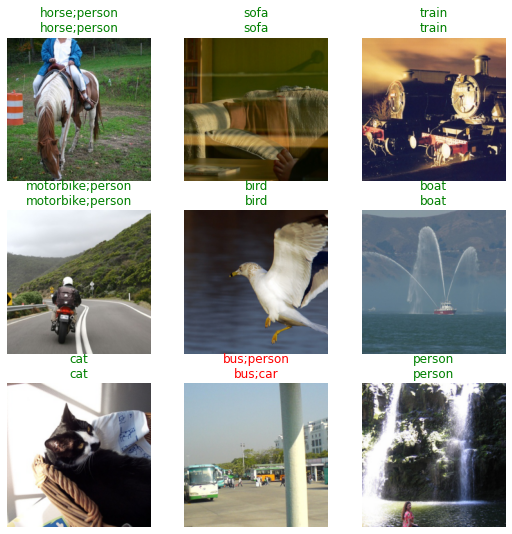

In [ ]:
learn.show_results()

## Inference

In [ ]:
# Display a couple of records
df.head(5)

In [ ]:
# Choose a example and get the image filename
fname = df.iloc[2]['fname']
fname
# '000009.jpg'

In [ ]:
# Full qualified image filename
img = path/"train"/fname
img
# Path('/root/.fastai/data/pascal_2007/train/000009.jpg')

In [ ]:
# Vocab
dls.vocab
# (#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

In [ ]:
# Predict
learn.predict(img)

In [ ]:
# Vocab: Zero-based indexing
dls.vocab[12], dls.vocab[14]

The prediction tensor (array):

`tensor([0.0024, 0.0267, 0.0154, 0.0129, 0.0090, 0.0097, 0.1945, 0.0035, 0.0710,
         0.0043, 0.0074, 0.0207, 0.8225, 0.0389, 0.9993, 0.0127, 0.0104, 0.0090,
         0.0060, 0.0292]))`

The threshold (`thresh=0.2`) is applied to the prediction array which leads to the following tensor (array):

`tensor([False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False,  True, False, False, False, False, False])`

Which corresponds to : `['horse','person']` - All the True positions



## Congratulations and Happy Learning!